<a href="https://colab.research.google.com/github/Phatdat01/FruitsRecognition/blob/main/FruitsImageTraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Notice:
Firstly make sure your images data is accepted:
https://stackoverflow.com/questions/64531236/unidentifiedimageerror-when-training-a-model-using-tf-imagegenerator

# Repair

In [ ]:
# Link to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Download TF Object Detection APi, tool for training
%cd /content
!git clone https://github.com/tensorflow/models.git

In [ ]:
# Compile the protos -  
# Protocol Buffers (Protobuf) is a free and open-source cross-platform data format used to serialize structured data.
%cd /content/models/research
!protoc object_detection/protos/*.proto --python_out=.

/content/models/research


In [ ]:
# Install TF_OJ_API
%cd /content/models/research
!cp object_detection/packages/tf2/setup.py . 
!python -m pip install .


In [ ]:
## Install tensorflow 
!pip install tensorflow==2.8
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

In [ ]:
# Test API
%cd /content/models/research
!python object_detection/builders/model_builder_tf2_test.py

## Download some files, data for training

In [ ]:
# Download some file, all of them are edited, this is some files and data for training
%cd /content
!gdown 1jcFpqey6etc2fTxFQJaJdy9yVP7vyavs
!gdown 1aLtrm_nkoI_VBiwcP7PYnSfAI0sDXduD
!gdown 16ULnotRnmOj7g2o6z3ytfrE0CXjz1NB2

In [ ]:
# Extract
%cd /content
!pip install patool

import patoolib
import os
import shutil
!mkdir /content/pretrained

patoolib.extract_archive("images.rar", outdir="/content")
os.remove("images.rar")
patoolib.extract_archive("Video.rar", outdir="/content/pretrained")
os.remove("Video.rar")

## Or you can make by yourself

create labels: see /content/pretrained/annotations/label_map.pbtxt

Create record

In [ ]:
# Download file generate_tfrecord.py, this help your path list of image to a record file
%cd /content
!wget https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/_downloads/da4babe668a8afb093cc7776d7e630f3/generate_tfrecord.py

In [ ]:
# 8. create record, it's in /content/pretrained/annotations/
%cd /content
!python generate_tfrecord.py -x /content/images/train -l /content/pretrained/annotations/label_map.pbtxt -o /content/pretrained/annotations/train.record
!python generate_tfrecord.py -x /content/images/test -l /content/pretrained/annotations/label_map.pbtxt -o /content/pretrained/annotations/test.record


Download config file vs pretrain

In [ ]:
%cd /content/pretrained

!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz
# Unzip
!tar -xzvf ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz
!rm ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz
!mv ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint .
!mv ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/pipeline.config /content
!rm -rf ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8

reconfigure config file: by yourself

# Training

Before that, update line 36

to

tf.keras.optimizers.Adam

In [ ]:
!mkdir /content/pretrained/pretrained
%cd /content/models/research/object_detection
#train 
!python model_main_tf2.py \
--pipeline_config_path=/content/pipeline.config \
--model_dir=/content/pretrained/pretrained --num_train_steps=1000

# Don't run on this if your data is oke

In [ ]:
### Tensorflow only accept ["bmp", "gif", "jpeg", "png"], orthers will not be accept, sometimes you can't change type by rename
from pathlib import Path
import imghdr
from PIL import Image

%cd /content/images
image_extensions = [".jpg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]

def edit(data_dir):
  num=0
  lstfile=Path(data_dir).rglob("*")
  for file in lstfile:
    if file.suffix.lower() in image_extensions:
        img_type = imghdr.what(file)
        ## I just convert all file type to jpeg, it's only change 
        if img_type !="jpeg":
          print(str(file))
          index=file.rindex(".")
          image = Image.open(file)
          image = image.convert('RGB')
          image.save(file[:index]+".jpg")
          num+=1
  return num

dir = "test"
numfiledit=edit(dir)
print(numfiledit)
print("##############\nafter edit")
numfiledit=edit(dir)
print(numfiledit)

In [ ]:
# %cd /content
# import shutil
# shutil.make_archive("/content/pretrained/new", 'zip', "/content/pretrained")
# shutil.copy("/content/pretrained/new.zip","/content/drive/MyDrive")

/content


'/content/pretrained/pretrained.zip'

# Export model

In [ ]:
# Export model
# %cd /content/models/research
# %cp /content/models/research/object_detection/exporter_main_v2.py .
%cd /content/models/research/object_detection

!python exporter_main_v2.py \
--trained_checkpoint_dir=/content/pretrained/pretrained \
--pipeline_config_path=/content/pipeline.config \
--output_directory=/content/pretrained/new

# Test

In [ ]:
import io
import os
import scipy.misc
import numpy as np
import six
import time
import glob
from IPython.display import display
from six import BytesIO
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import tensorflow as tf
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util
import cv2

#Load model
tf.keras.backend.clear_session()
model = tf.saved_model.load("/content/pretrained/new/saved_model")

In [ ]:
def recognize(model, image):
  
  image = np.asarray(image)
  input_tensor = tf.convert_to_tensor(image)
  input_tensor = input_tensor[tf.newaxis,...]
  model_fn = model.signatures['serving_default']
  output_dict = model_fn(input_tensor)

  num_detections = int(output_dict.pop('num_detections'))
  output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
  output_dict['num_detections'] = num_detections
  output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
   
  if 'detection_masks' in output_dict:
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              output_dict['detection_masks'], output_dict['detection_boxes'],
               image.shape[0], image.shape[1])      
    detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                       tf.uint8)
    output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
  return output_dict

def load_image_into_numpy_array(path):
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

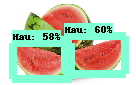

In [ ]:
category_index = label_map_util.create_category_index_from_labelmap("/content/pretrained/annotations/label_map.pbtxt", use_display_name=True)

image_path = '/content/DuaHau.jpg'
image_np = load_image_into_numpy_array(image_path)
image_np = cv2.resize(image_np, dsize=None, fx=0.2, fy=0.2)
output_dict = recognize(model, image_np)
vis_util.visualize_boxes_and_labels_on_image_array(
    image_np,
    output_dict['detection_boxes'],
    output_dict['detection_classes'],
    output_dict['detection_scores'],
    category_index,
    instance_masks=output_dict.get('detection_masks_reframed', None),
    use_normalized_coordinates=True,
    line_thickness=8)
display(Image.fromarray(image_np))